In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from scipy.stats import gaussian_kde
import matplotlib.patheffects as path_effects



---
---

# CLEANING

---

### DESCRIBE

In [2]:
df = pd.read_csv('data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

---

### CLEAN

In [4]:
df['TotalCharges'] = df['TotalCharges'].replace({' ':'0'})
df['TotalCharges'] = df['TotalCharges'].astype(float)/df['tenure']

df = df.fillna(0.)

---

### DUMMIFY

In [5]:
to_replace = {
    'No' : 0,
    'Yes': 1
}

for c in ['Partner','Dependents','PhoneService', 'PaperlessBilling', 'Churn']:
    df[c] = df[c].map(to_replace)

In [6]:
to_replace = {
    'Female' : 0,
    'Male' : 1
}

df['gender'] = df['gender'].map(to_replace)

In [7]:
to_replace = {
    'No phone service': 0,
    'No': 1,
    'Yes': 2
}

df['MultipleLines'] = df['MultipleLines'].map(to_replace)

In [8]:
to_replace = {
    'DSL' : 1,
    'Fiber optic': 2,
    'No' : 0
}

df['InternetService'] = df['InternetService'].map(to_replace)

In [9]:
to_replace = {
    'No' : 0,
    'Yes': 1,
    'No internet service' : 0
}

for c in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[c] = df[c].map(to_replace)

In [10]:
to_replace = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}

df['Contract'] = df['Contract'].map(to_replace)

In [11]:
df = pd.get_dummies(df, columns=['PaymentMethod'], prefix='PaymentMethod', drop_first=True, dtype=int)

---
---

# COHORT ANALYSIS

In [12]:
df['tenure_cohort'] = pd.cut(list(df['tenure']),[0, 12, 24, float('inf')], labels=['0 - 12', '12 - 24', '25+'])

In [13]:
cohort_data = df.groupby('tenure_cohort')['Churn'].mean()
cohort_data

C:\Users\UY641FU\AppData\Local\Temp\ipykernel_57356\986608696.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_data = df.groupby('tenure_cohort')['Churn'].mean()


tenure_cohort
0 - 12     0.476782
12 - 24    0.287109
25+        0.140360
Name: Churn, dtype: float64

---
---

# LTV MODEL 

---

### LIFETIME PREDICTION WITH REGRESSION

Lifetimes are known for churned clients: by training a regressor model on this cohort, we can then predict the total tenure of other clients, hence their LTV

In [14]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [15]:
df_churned = df.loc[df['Churn'] == 1]

In [16]:
X = df_churned.drop(['Churn','tenure'],axis=1).select_dtypes(['number'])
y = df_churned['tenure']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [18]:
model = RandomForestRegressor()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [19]:
regression_results(y_test,y_pred)

explained_variance:  0.4421
mean_squared_log_error:  0.9957
r2:  0.4319
MAE:  10.1172
MSE:  195.605
RMSE:  13.9859


In [20]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [3,5,7,8,10],
    'min_samples_leaf': [ 4, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", grid_search.best_score_)


Fitting 3 folds for each of 135 candidates, totalling 405 fits


C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 200}
Best Negative Mean Squared Error: -182.47241901522634


In [21]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

regression_results(y_test,y_pred)

explained_variance:  0.4713
mean_squared_log_error:  0.9443
r2:  0.4687
MAE:  9.8287
MSE:  182.937
RMSE:  13.5254


---

### SURVIVAL ANALYSIS

Survival analysis does not require to remove customers that didn't churn, so it's more robust

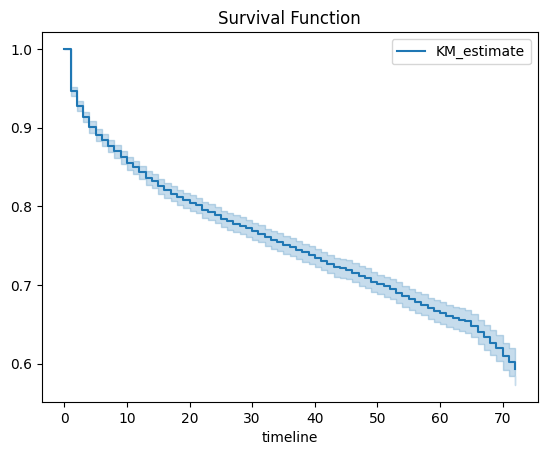

12    0.843200
24    0.788736
36    0.748545
48    0.708840
60    0.664404
72    0.592790
Name: KM_estimate, dtype: float64

In [22]:
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(df['tenure'], event_observed=df['Churn'])

# Plot survival function
kmf.plot_survival_function()
plt.title('Survival Function')
plt.show()

predicted_survival = kmf.survival_function_at_times([12, 24, 36, 48, 60, 72])
predicted_survival

In [23]:
cph = CoxPHFitter()

# Select relevant features and fit the model
cph.fit(df.select_dtypes(['number']), 'tenure', event_col='Churn')

# View results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13894.24
         time fit was run = 2024-12-17 15:43:15 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                -0.09      0.92      0.05           -0.18            0.00                0.84                1.00
SeniorCitizen                         -0.08      0.93      0.06           -0.19            0.03                0.83                1.03
Partner                               -0.53      0.59      0.06           -0.63           -0.42                0.53                0.66
Dependents                            -0.05      0.95      0.07           -0.19            0.08                0.83                1.09
PhoneService                           0.45      1.56      0.36           -0.27            1.16                0.76                3.19
MultipleLines                         -0.44      0.64      0.13           -0.69           -0.19                0.50                0.83
InternetService                        0.79      2.20      0.57           -0.34            1.91                0.71                6.77
OnlineSecurity                        -0.57      0.57      0.13           -0.83           -0.30                0.44                0.74
OnlineBackup                          -0.61      0.55      0.13           -0.85           -0.36                0.43                0.70
DeviceProtection                      -0.28      0.76      0.13           -0.52           -0.03                0.59                0.97
TechSupport                           -0.33      0.72      0.13           -0.59           -0.07                0.55                0.93
StreamingTV                            0.02      1.02      0.24           -0.44            0.48                0.64                1.62
StreamingMovies                       -0.07      0.93      0.24           -0.54            0.39                0.58                1.47
Contract                              -1.65      0.19      0.07           -1.78           -1.52                0.17                0.22
PaperlessBilling                       0.19      1.21      0.06            0.08            0.30                1.08                1.35
MonthlyCharges                        -0.01      0.99      0.02           -0.06            0.04                0.94                1.04
TotalCharges                           0.00      1.00      0.01           -0.01            0.02                0.99                1.02
PaymentMethod_Credit card (automatic) -0.09      0.92      0.09           -0.26            0.09                0.77                1.10
PaymentMethod_Electronic check         0.58      1.79      0.07            0.44            0.72                1.56                2.06
PaymentMethod_Mailed check             0.56      1.75      0.09            0.39            0.74                1.48                2.09

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00  -1.88   0.06      4.06
SeniorCitizen                            0.00  -1.36   0.17      2.51
Partner                                  0.00  -9.54 <0.005     69.22
Dependents                               0.00  -0.76   0.45      1.17
PhoneService                             0.00   1.22   0.22      2.18
MultipleLines                            0.00  -3.47 <0.005     10.93
InternetService                          0.00   1.37   0.17      2.55
OnlineSecuri

---

### LTV COMPUTATION

In [24]:
active_customers = df[df['Churn'] == 0].copy()

active_customers['expected_lifetime_cph'] = cph.predict_expectation(active_customers)
active_customers['expected_lifetime_rf'] = model.predict(active_customers.select_dtypes(['number']).drop(['Churn','expected_lifetime_cph','tenure'],axis=1))

In [25]:
active_customers['LTV_cph'] = active_customers['expected_lifetime_cph']*active_customers['TotalCharges']
active_customers['LTV_rf'] = active_customers['expected_lifetime_rf']*active_customers['TotalCharges']


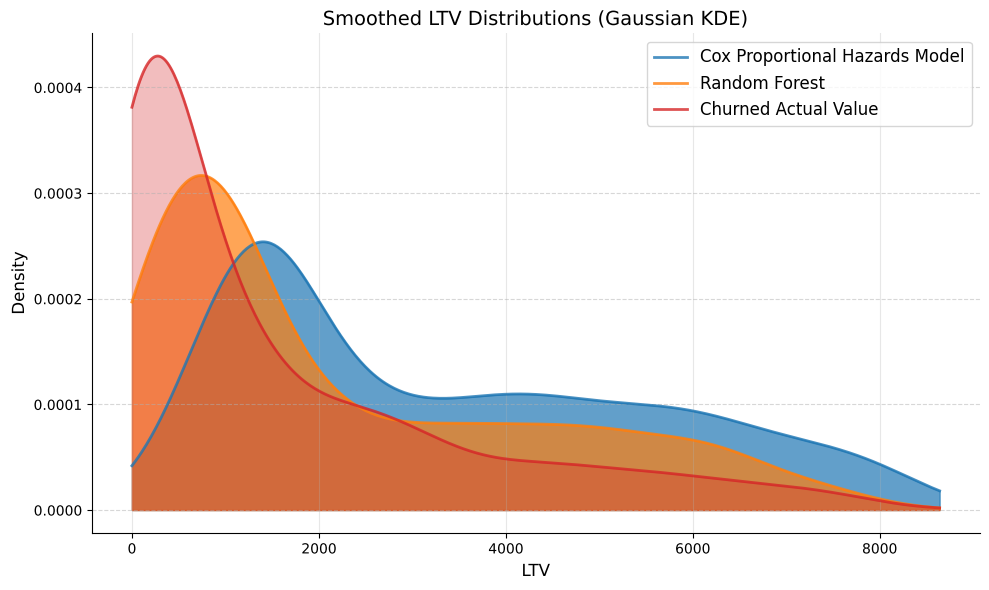

In [69]:
# Extract LTV values for the two models
ltv_cph = active_customers['LTV_cph']
ltv_rf = active_customers['LTV_rf']
ltv_churned = df_churned['TotalCharges']*df_churned['tenure']

bwm = 0.25

# Define KDE for both distributions
kde_cph = gaussian_kde(ltv_cph, bw_method=bwm)  # Adjust `bw_method` for smoothing level
kde_rf = gaussian_kde(ltv_rf, bw_method=bwm)
kde_churned = gaussian_kde(ltv_churned, bw_method=bwm)

# Create a range of x values for smooth plotting
x_range = np.linspace(min(ltv_cph.min(), ltv_rf.min()), max(ltv_cph.max(), ltv_rf.max()), 500)

# Evaluate KDE for both models
kde_cph_values = kde_cph(x_range)
kde_rf_values = kde_rf(x_range)
kde_churned_values = kde_churned(x_range)

# Plot the KDE distributions
plt.figure(figsize=(10, 6))

plt.plot(x_range, kde_cph_values, label='Cox Proportional Hazards Model', color='C0', linewidth=2, alpha=0.8)
plt.plot(x_range, kde_rf_values, label='Random Forest', color='C1', linewidth=2, alpha=0.8)
plt.plot(x_range, kde_churned_values, label='Churned Actual Value', color='C3', linewidth=2, alpha=0.8)

# Add labels, legend, and formatting
plt.fill_between(x_range, kde_cph_values, alpha=0.7, color='C0')  # Add shaded area under the curve
plt.fill_between(x_range, kde_rf_values, alpha=0.7, color='C1')
plt.fill_between(x_range, kde_churned_values, alpha=0.3, color='C3')

plt.title('Smoothed LTV Distributions (Gaussian KDE)', fontsize=14)
plt.xlabel('LTV', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add white outlines to all text elements (axes labels, ticks, and titles)
ax = plt.gca()
texts = [ax.title, ax.xaxis.label, ax.yaxis.label]  # Title, xlabel, ylabel
texts += ax.get_xticklabels() + ax.get_yticklabels()  # Tick labels

# Apply white outlines to each text object
for text in texts:
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
        path_effects.Normal()  # Normal text rendering
    ])

# Tight layout and save as a transparent image
plt.tight_layout()
plt.savefig('artifacts/imgs/predicted_LTV.png', transparent=True)

# Display the plot
plt.show()

---
---

# LTV ANALYSIS

---

### LTV SEGMENTS

In [27]:
active_customers['LTV_segments'] = pd.cut(active_customers['LTV_cph'],bins=[0,3000,6000,100000],labels=['Bronze','Silver','Gold'])

In [28]:
ltv_segments_recap = active_customers.groupby('LTV_segments').size().reset_index(name='count')
ltv_segments_recap['percentage'] = (ltv_segments_recap['count'] / ltv_segments_recap['count'].sum()) * 100
ltv_segments_recap

C:\Users\UY641FU\AppData\Local\Temp\ipykernel_57356\785097125.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltv_segments_recap = active_customers.groupby('LTV_segments').size().reset_index(name='count')


,LTV_segments,count,percentage
0,Bronze,2685,52.004648
1,Silver,1621,31.396475
2,Gold,857,16.598877


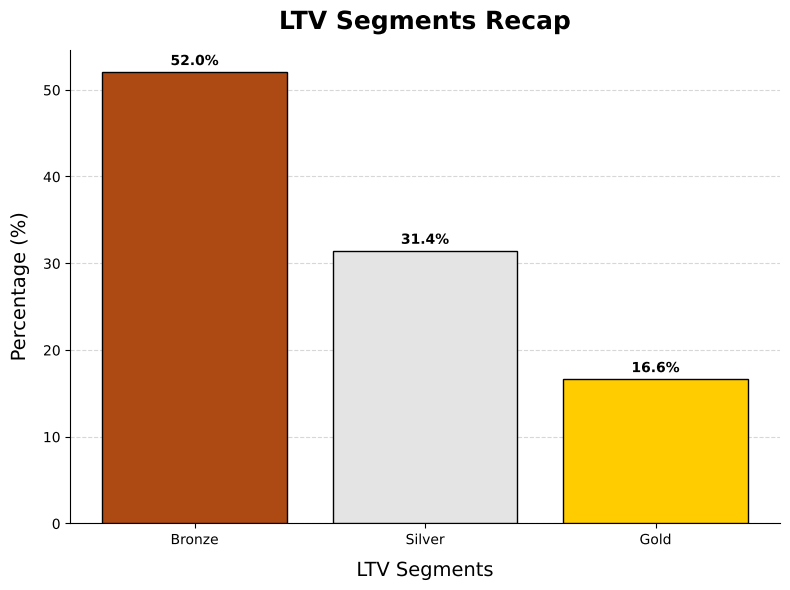

In [65]:
# Colors for the segments
colors = {'Bronze': '#AD4A13', 'Silver': '#E4E4E4', 'Gold': '#FFCC00'}

# Plot the data
plt.figure(figsize=(8, 6))

# Create the bar plot with a modern style
bars = plt.bar(
    ltv_segments_recap['LTV_segments'], 
    ltv_segments_recap['percentage'], 
    color=[colors[segment] for segment in ltv_segments_recap['LTV_segments']],
    edgecolor='black',  # Add a black border for better contrast
    linewidth=1,
    zorder=10
)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center horizontally
        height + 0.5,  # Slightly above the bar
        f'{height:.1f}%', 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black', 
        fontweight='bold',
        zorder=15,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
            path_effects.Normal()  # Normal text rendering
        ]
    )

# Add titles and labels
plt.title('LTV Segments Recap', fontsize=18, pad=15, fontweight='bold')
plt.xlabel('LTV Segments', fontsize=14, labelpad=10)
plt.ylabel('Percentage (%)', fontsize=14, labelpad=10)

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add white outlines to all text elements (axes labels, ticks, and titles)
ax = plt.gca()
texts = [ax.title, ax.xaxis.label, ax.yaxis.label]  # Title, xlabel, ylabel
texts += ax.get_xticklabels() + ax.get_yticklabels()  # Tick labels

# Apply white outlines to each text object
for text in texts:
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
        path_effects.Normal()  # Normal text rendering
    ])

# Tight layout and save as a transparent image
plt.tight_layout()
plt.savefig('artifacts/imgs/LTV_segments_recap.png', transparent=True, dpi=300)

# Display the plot
plt.show()

In [30]:
df_cluster = pd.read_csv('data/raw/telco_clusters.csv')

active_customers = pd.merge(active_customers,df_cluster[['cluster','cluster_name']],left_index=True, right_index=True, how='left')

In [31]:
ltv_cluster_recap = active_customers.groupby(['cluster_name','LTV_segments']).size().reset_index(name='count')

ltv_cluster_recap['cluster_total'] = ltv_cluster_recap.groupby('cluster_name')['count'].transform('sum')

# Calculate the percentage for each segment within the cluster
ltv_cluster_recap['percentage'] = (ltv_cluster_recap['count'] / ltv_cluster_recap['cluster_total']) * 100

# Drop the cluster_total column if not needed
ltv_cluster_recap.drop(columns=['cluster_total'], inplace=True)

# View the result
ltv_cluster_recap

C:\Users\UY641FU\AppData\Local\Temp\ipykernel_57356\2263966430.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltv_cluster_recap = active_customers.groupby(['cluster_name','LTV_segments']).size().reset_index(name='count')


,cluster_name,LTV_segments,count,percentage
0,mail check payers,Bronze,906,77.901978
1,mail check payers,Silver,203,17.454858
2,mail check payers,Gold,54,4.643164
3,no phone service,Bronze,324,63.529412
4,no phone service,Silver,186,36.470588
5,no phone service,Gold,0,0.000000
6,senior high spenders,Bronze,146,27.651515
7,senior high spenders,Silver,221,41.856061
8,senior high spenders,Gold,161,30.492424
9,young credit card users,Bronze,410,39.844509


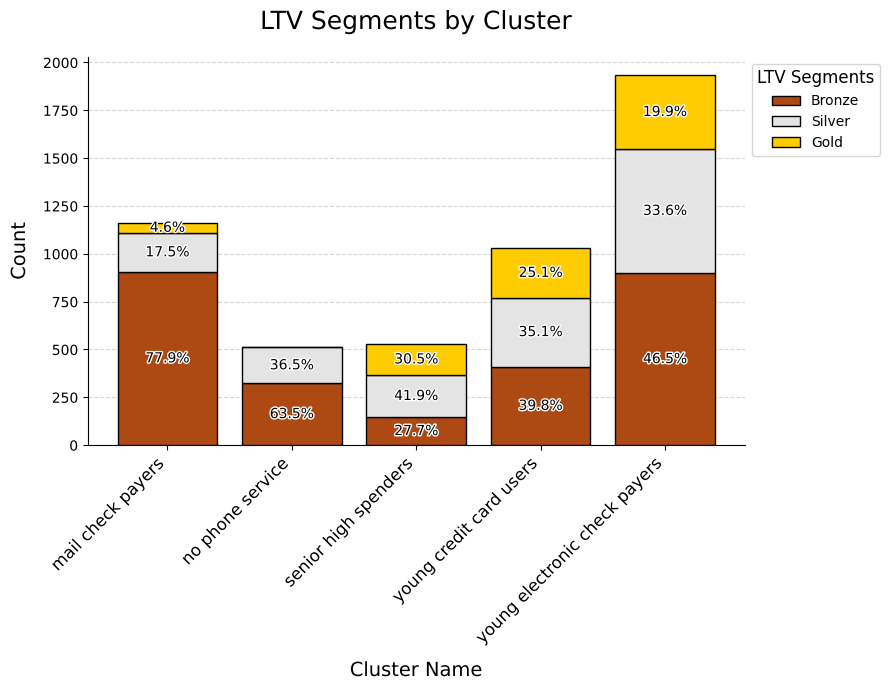

In [ ]:
segment_colors = {'Bronze': '#AD4A13', 'Silver': '#E4E4E4', 'Gold': '#FFCC00'}

# Pivot the DataFrame to make it suitable for stacked bar plotting
ltv_cluster_pivot = ltv_cluster_recap.pivot(index='cluster_name', columns='LTV_segments', values='count').fillna(0)
ltv_percentage_pivot = ltv_cluster_recap.pivot(index='cluster_name', columns='LTV_segments', values='percentage').fillna(0)

# Plot each LTV segment as a stacked layer
fig, ax = plt.subplots(figsize=(9, 7))
bottom = None

# Loop through each segment and create stacked bars
for segment in ltv_cluster_pivot.columns:
    percentage_in_cluster = list(ltv_percentage_pivot[segment])
    bars = ax.bar(
        ltv_cluster_pivot.index, 
        ltv_cluster_pivot[segment], 
        label=segment, 
        color=segment_colors[segment], 
        bottom=bottom,
        edgecolor='black',  # Add a black border for better contrast
        linewidth=1,
        zorder=10
    )

    bottom = ltv_cluster_pivot[segment] if bottom is None else bottom + ltv_cluster_pivot[segment]
    
    # Add annotations (count and percentage) on each bar segment
    for i,bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Avoid annotating zero values
            # Calculate the percentage for this segment
            cluster_name = bar.get_x() + bar.get_width() / 2  # Get x position of the bar
            percentage = percentage_in_cluster[i]

            # Annotate the count and percentage (1 decimal place)
            # ax.text(
            #     bar.get_x() + bar.get_width() / 2, 
            #     bar.get_y() + height / 2, 
            #     f'{percentage:.1f}%', 
            #     ha='center', 
            #     va='center', 
            #     fontsize=10, 
            #     color='black',
            #     zorder=15
            # )

            # Add annotations with a white outline around the text
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_y() + height / 2, 
                f'{percentage:.1f}%', 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='black',  # Text color
                zorder=15,
                path_effects=[
                    path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
                    path_effects.Normal()  # Normal text rendering
                ]
            )

# Add titles and labels
ax.set_title('LTV Segments by Cluster', fontsize=18, pad=20)
ax.set_xlabel('Cluster Name', fontsize=14, labelpad=10)
ax.set_ylabel('Count', fontsize=14, labelpad=10)

# Customize ticks
ax.set_xticks(range(len(ltv_cluster_pivot.index)))
ax.set_xticklabels(ltv_cluster_pivot.index, rotation=45, ha='right', fontsize=12)

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add gridlines only on the y-axis for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add white outlines to all text elements (axes labels, ticks, and titles)
ax = plt.gca()
texts = [ax.title, ax.xaxis.label, ax.yaxis.label]  # Title, xlabel, ylabel
texts += ax.get_xticklabels() + ax.get_yticklabels()  # Tick labels

# Apply white outlines to each text object
for text in texts:
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
        path_effects.Normal()  # Normal text rendering
    ])

# Add a legend
ax.legend(title='LTV Segments', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Tight layout and save as a transparent image
plt.tight_layout()
plt.savefig('artifacts/imgs/LTV_clusters_recap.png', transparent=True)

# Display the plot
plt.show()
